In [72]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

plt.style.use("ggplot")

# df = pd.read_csv('/content/News_Articles.csv', index_col=0)
df = pd.read_json('../data/News_Category_Dataset_v2.json', lines=True)

df.head()


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [73]:
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(200853, 6)
Unique categories: 41
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [74]:
# general descrption of dataset
df.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,date
count,200853
mean,2015-02-06 05:55:12.542008576
min,2012-01-28 00:00:00
25%,2013-07-18 00:00:00
50%,2015-01-25 00:00:00
75%,2016-08-19 00:00:00
max,2018-05-26 00:00:00


In [75]:
# drop columns like authors, links and date as they are irrelevent to our problem.
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."


In [76]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(new_df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

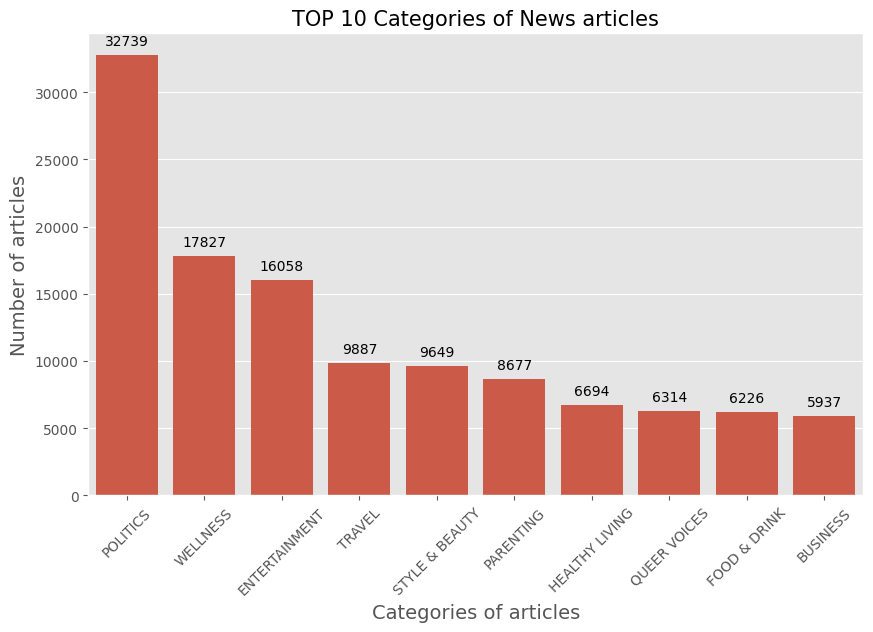

In [77]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(new_df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'news_classes'}, inplace=True)

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cat_df['news_classes'][:10], y=cat_df['count'][:10])
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title("TOP 10 Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

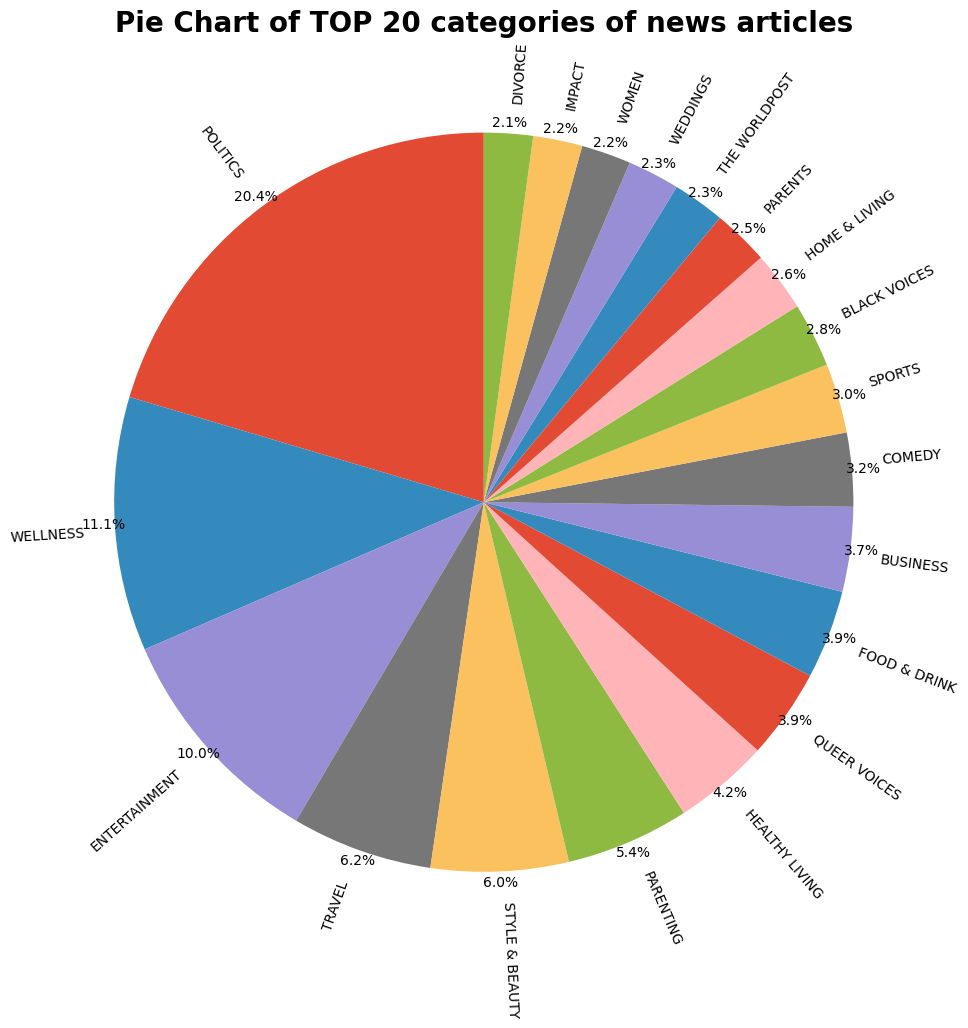

In [78]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['count'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles", size=20, weight='bold')
plt.show()

In [79]:
# create final dataframe of combined headline and short_description
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,category,length_of_news,len_news
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,140
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,99
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,134
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,155
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,158


In [80]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,category,len_news
24,POLITICS,1486
40,WORLDPOST,1424
4,COLLEGE,1225
16,HEALTHY LIVING,1073
37,WELLNESS,1036


In [81]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,category,len_news
8,DIVORCE,66
33,THE WORLDPOST,56
35,WEDDINGS,54
21,MONEY,51
39,WORLD NEWS,51


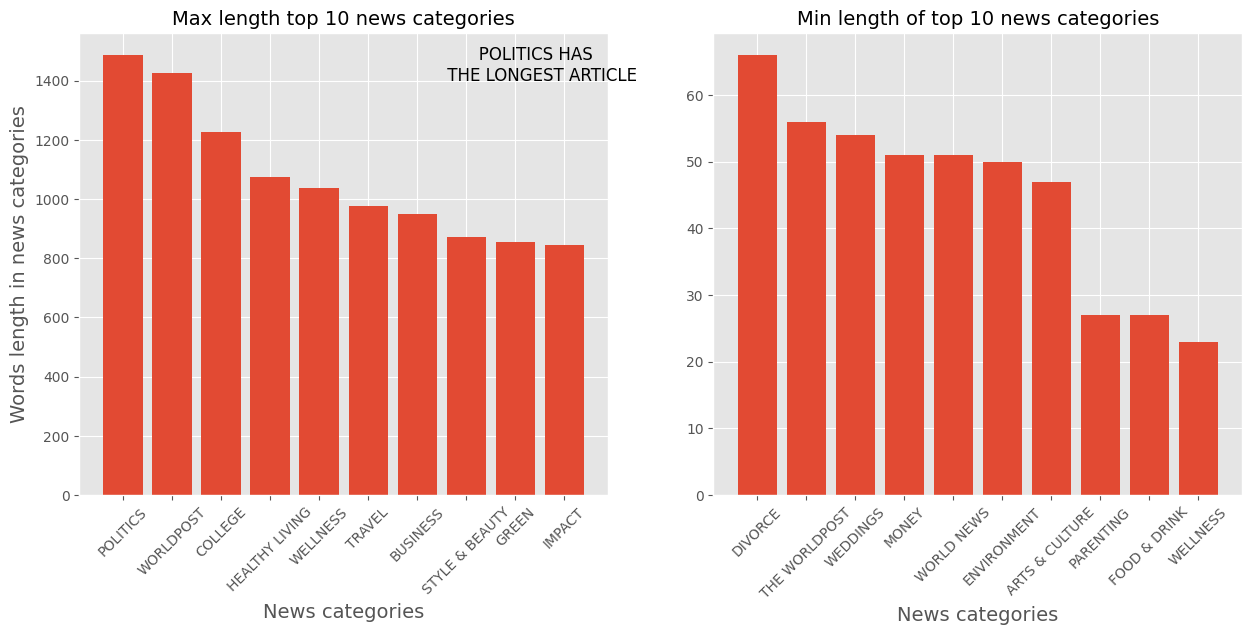

In [82]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

In [83]:
# Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
STOPWORDS = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

(-0.5, 1599.5, 599.5, -0.5)

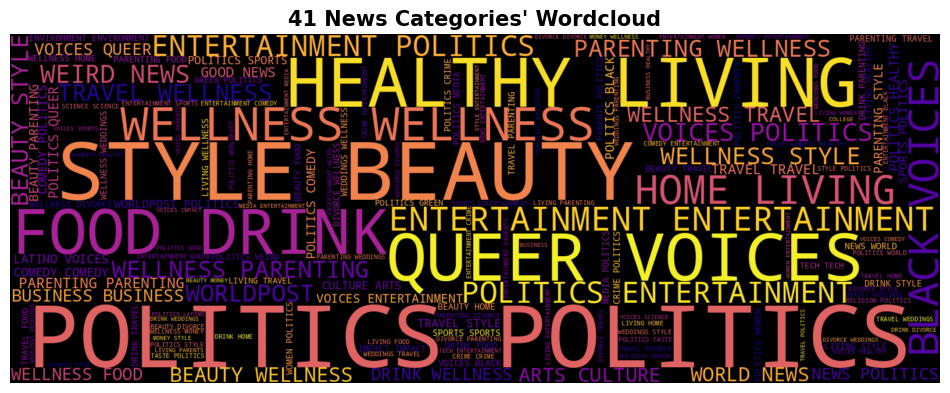

In [84]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_df.category))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

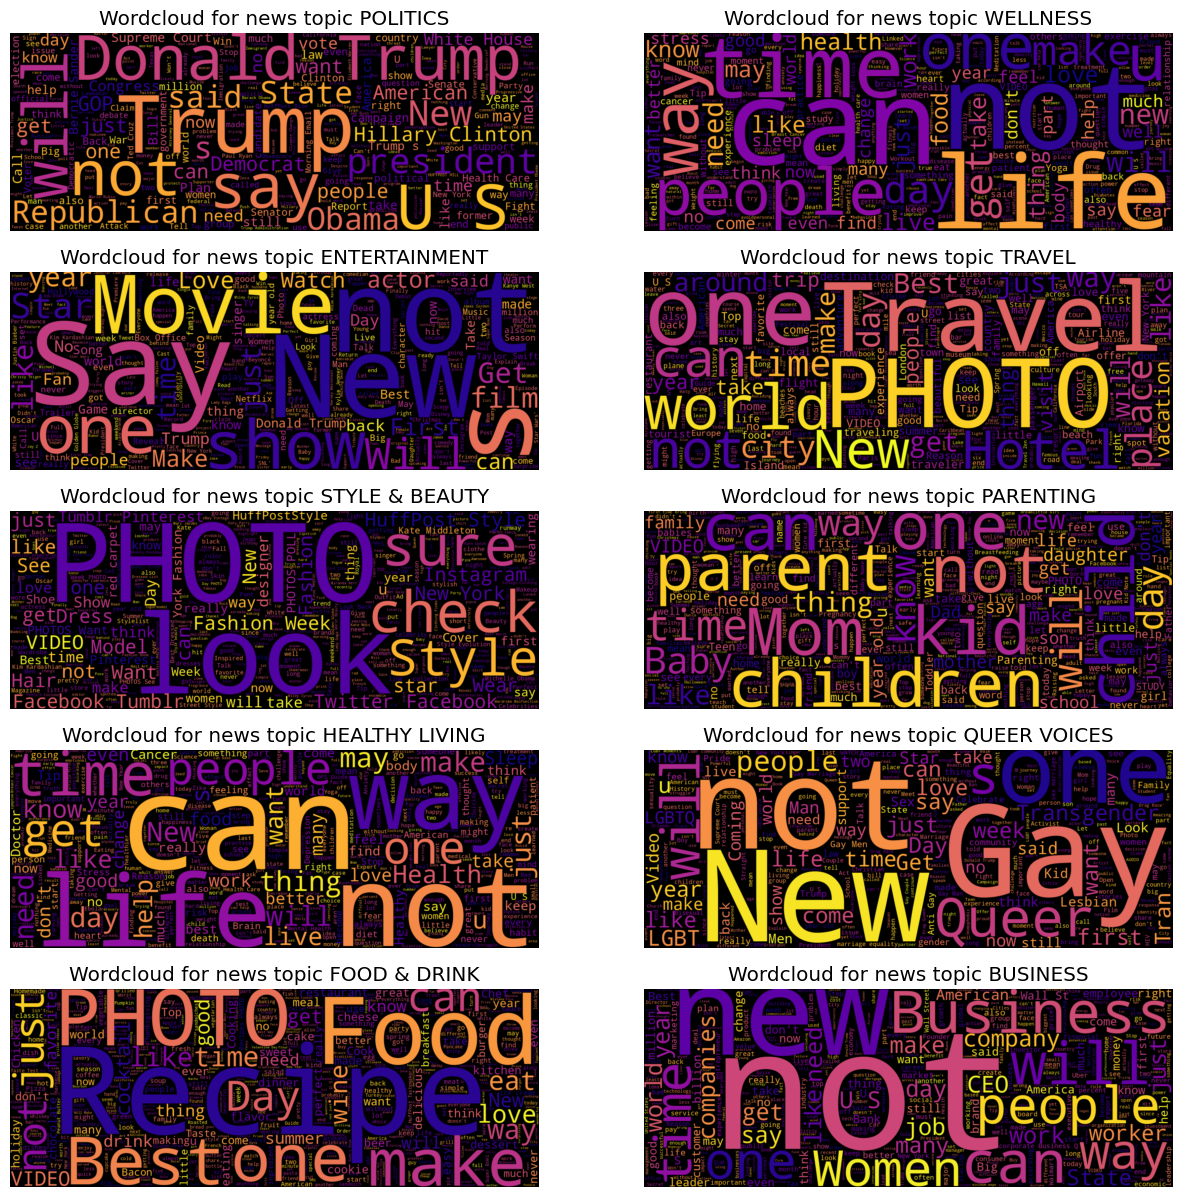

In [85]:
# create new dataframe of category and length of each news articles in that categories
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

In [86]:
# start with removing some data from politics dataframe ndf
politics_list = list(ndf[ndf['category'] == 'POLITICS'].index)
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

# drop these 16000 labels from the dataset
ndf2 = ndf.copy()
ndf2.drop(list_16, axis=0, inplace=True)

In [87]:
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()

    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/var/folders/9c/nflqrr9131d0fbbm5r8_024r0000gn/T/ipykernel_61168/774379672.py:8: SyntaxWarning: invalid escape sequence '\d'
  text = re.sub("\d+", "", text)


In [88]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/juwon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/juwon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [89]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n",ndf2['length_of_news'][0])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(ndf2['length_of_news'][0]))

Text sentence before pre-processing:
 There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TVShe left her husband. He killed their children. Just another day in America.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 mass shoot texas last week tvshe leave husband kill children just another day america


In [90]:
# apply datacleaning function to column 'length_of_news'
ndf2['length_of_news'] = ndf2['length_of_news'].apply(datacleaning)

In [91]:
# length of total characters before and after cleaning text data
old_length = ndf['length_of_news'].apply(len).sum()
new_length = ndf2['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 34597530
New chracters length of text data: 22373504


In [92]:
# length of total words before and after cleaning text data
old_text = ndf['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = ndf2['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 5697195
New word length of text data: 3230689


In [93]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(ndf2['length_of_news'][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words

max_length = 15

results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1))

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 74)
Token index of unique words: 
 {'mass': 1, 'shoot': 2, 'texas': 3, 'last': 4, 'week': 5, 'tvshe': 6, 'leave': 7, 'husband': 8, 'kill': 9, 'children': 10, 'just': 11, 'another': 12, 'day': 13, 'america': 14, 'will': 15, 'smith': 16, 'join': 17, 'diplo': 18, 'nicky': 19, 'jam': 20, 'world': 21, 'cup': 22, 'official': 23, 'songof': 24, 'course': 25, 'song': 26, 'hugh': 27, 'grant': 28, 'marry': 29, 'first': 30, 'time': 31, 'age': 32, 'actor': 33, 'longtime': 34, 'girlfriend': 35, 'anna': 36, 'eberstein': 37, 'tie': 38, 'knot': 39, 'civil': 40, 'ceremony': 41, 'jim': 42, 'carrey': 43, 'blast': 44, 'castrato': 45, 'adam': 46, 'schiff': 47, 'democrats': 48, 'new': 49, 'artworkthe': 50, 'give': 51, 'dems': 52, 'asskicking': 53, 'not': 54, 'fight': 55, 'hard': 56, 'enough': 57, 'donald': 58, 'trump': 59, 'julianna': 60, 'margulies': 61, 'use': 62, 'poop': 63, 'bag': 64, 'pick': 65, 'dogthe': 66, 'dietland': 67, 'actress': 68, 'say': 69, 'really': 70, 

In [94]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [95]:

# one hot encoding using keras tokenizer and pad sequencing
X = ndf2['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf2['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train)  # build the word index

# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train)  # converts strings into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20)  # pads the integer lists to 2D integer tensor

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 130  # max length of sequence
y_train = to_categorical(y_train, num_classes=41)
y_test = to_categorical(y_test, num_classes=41)
print("Length of word index:", total_words)

shape of input data:  (184853,)
shape of target variable:  (184853,)
Length of word index: 174766


In [98]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh')))
model.add(Dropout(0.2))
model.add(Dense(41, activation='softmax'))
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_36                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_37                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [99]:
import tensorflow as tf 
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                 patience=5,
                                                 verbose=1,
                                                 mode='min')

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='bestvalue.keras', monitor='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train, 
                    batch_size=128, 
                    epochs=15, 
                    validation_split=0.2, 
                    callbacks=callback_list)

# evaluate the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
925/925 ━━━━━━━━━━━━━━━━━━━━ 73s 77ms/step - accuracy: 0.1905 - loss: 3.1002 - val_accuracy: 0.3679 - val_loss: 2.3966
Epoch 2/15
599/925 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.4081 - loss: 2.2599

In [ ]:
model.save("news_classifier_exp01.h5")

In [ ]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

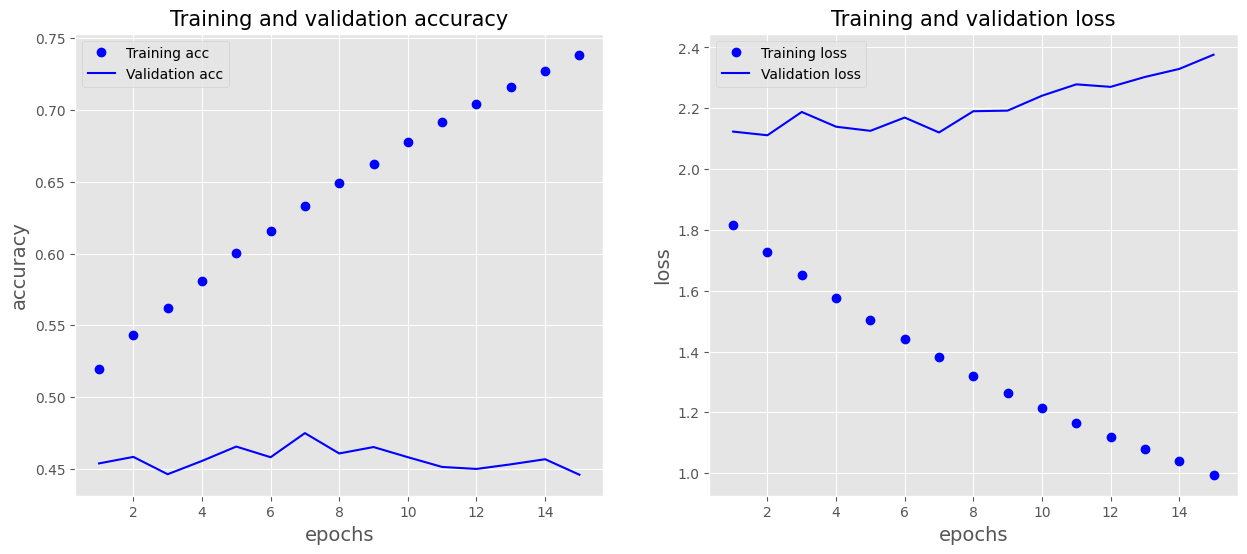

In [ ]:
plot_loss_accuracy(history)